In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import BertModel, BertTokenizer, get_linear_schedule_with_warmup
from torch.optim import AdamW
from torch.nn.utils import clip_grad_norm_
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
from sklearn.preprocessing import LabelEncoder

# 多分类标签编码处理函数（映射为二分类）
def load_and_prepare_binary_data(train_path, val_path, test_path):
    train_df = pd.read_csv(train_path)
    val_df = pd.read_csv(val_path)
    test_df = pd.read_csv(test_path)

    def remap_labels(df):
        df["label"] = df["label"].map(lambda x: 0 if x in [0, 1, 2] else 1)  # 0=fake, 1=real
        return df

    train_df = remap_labels(train_df)
    val_df = remap_labels(val_df)
    test_df = remap_labels(test_df)

    return train_df, val_df, test_df, ["fake", "real"]



In [3]:
from torch.utils.data import DataLoader
import torch

def predict(model, dataset, batch_size=16):
    loader = DataLoader(dataset, batch_size=batch_size)
    model.eval()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    predictions = []

    with torch.no_grad():
        for batch in loader:
            inputs = {k: v.to(device) for k, v in batch.items() if k != 'labels'}
            outputs = model(**inputs)
            preds = torch.argmax(outputs, dim=1)
            predictions.extend(preds.cpu().numpy())

    return predictions


In [4]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix

def analyze_predictions(preds, test_df, label_col="label", label_map={0: "fake", 1: "real"}, top_k=5):
    true_labels = test_df[label_col].tolist()

    print("📊 Classification Report:")
    print(classification_report(true_labels, preds, target_names=["fake", "real"]))

    # 混淆矩阵
    cm = confusion_matrix(true_labels, preds)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=["fake", "real"], yticklabels=["fake", "real"])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()

    # 错误样本
    test_df["true_label"] = test_df[label_col]
    test_df["predicted_label"] = preds
    test_df["correct"] = test_df["true_label"] == test_df["predicted_label"]

    print(f"\n❌ Top {top_k} Misclassified Samples:\n")
    mistakes = test_df[~test_df["correct"]].head(top_k)
    for i, row in mistakes.iterrows():
        print(f"[{i}] Statement: {row['clean_statement_bert']}")
        print(f"    ➤ True: {label_map[row['true_label']]} | Pred: {label_map[row['predicted_label']]}")
        print("")

    return test_df


In [5]:
# ---------- Dataset ----------
class MultiClassFakeNewsDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_len):
        #self.texts = dataframe["clean_statement_bert"].tolist()
        self.texts = dataframe["statement"].tolist()
        self.labels = dataframe["label"].tolist()
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        encodings = self.tokenizer(
            self.texts[idx],
            padding='max_length',
            truncation=True,
            max_length=self.max_len,
            return_tensors='pt'
        )
        return {
            'input_ids': encodings['input_ids'].squeeze(0),
            'attention_mask': encodings['attention_mask'].squeeze(0),
            'labels': torch.tensor(self.labels[idx], dtype=torch.long)
        }

In [6]:
# ---------- Multi-Class BERT Model ----------
class MultiClassBERTClassifier(nn.Module):
    def __init__(self, model_name, num_labels=2, dropout=0.3):
        super().__init__()
        self.bert = BertModel.from_pretrained(model_name)
        self.dropout = nn.Dropout(dropout)
        self.classifier = nn.Linear(self.bert.config.hidden_size, num_labels)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        cls_output = outputs.pooler_output
        return self.classifier(self.dropout(cls_output))


In [7]:
# ---------- Training Function for Multi-Class ----------
def train_multiclass_model(train_dataset, val_dataset, model, epochs=6, batch_size=16, lr=5e-5, warmup_ratio=0.2, patience=2):
    optimizer = AdamW(model.parameters(), lr=lr)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    loss_fn = nn.CrossEntropyLoss()
    total_steps = len(train_loader) * epochs
    warmup_steps = int(warmup_ratio * total_steps)

    scheduler = get_linear_schedule_with_warmup(optimizer, warmup_steps, total_steps)

    train_losses, val_accuracies = [], []
    best_val_acc = 0
    patience_counter = 0

    for epoch in range(epochs):
        model.train()
        total_loss = 0

        for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
            inputs = {k: v.to(device) for k, v in batch.items() if k != 'labels'}
            labels = batch['labels'].to(device)

            optimizer.zero_grad()
            outputs = model(**inputs)
            loss = loss_fn(outputs, labels)
            loss.backward()
            clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            scheduler.step()
            total_loss += loss.item()

        avg_loss = total_loss / len(train_loader)
        train_losses.append(avg_loss)

        # Validation
        model.eval()
        correct, total = 0, 0
        with torch.no_grad():
            for batch in val_loader:
                inputs = {k: v.to(device) for k, v in batch.items() if k != 'labels'}
                labels = batch['labels'].to(device)
                outputs = model(**inputs)
                preds = torch.argmax(outputs, dim=1)
                correct += (preds == labels).sum().item()
                total += len(labels)
        acc = correct / total
        val_accuracies.append(acc)

        print(f"Epoch {epoch+1}: Train loss={avg_loss:.4f}, Val acc={acc:.4f}")

        if acc > best_val_acc:
            best_val_acc = acc
            patience_counter = 0
            torch.save(model.state_dict(), "best_multiclass_model.pt")
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("Early stopping.")
                break

    plt.plot(range(1, len(train_losses)+1), train_losses, label="Train Loss")
    plt.plot(range(1, len(val_accuracies)+1), val_accuracies, label="Validation Acc")
    plt.xlabel("Epoch")
    plt.legend()
    plt.title("Training Curve")
    plt.show()

    return model

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Epoch 1: 100%|██████████| 1149/1149 [06:33<00:00,  2.92it/s]


Epoch 1: Train loss=0.6085, Val acc=0.6970


Epoch 2: 100%|██████████| 1149/1149 [06:40<00:00,  2.87it/s]


Epoch 2: Train loss=0.5444, Val acc=0.7009


Epoch 3: 100%|██████████| 1149/1149 [06:40<00:00,  2.87it/s]


Epoch 3: Train loss=0.4294, Val acc=0.6926


Epoch 4: 100%|██████████| 1149/1149 [06:40<00:00,  2.87it/s]


Epoch 4: Train loss=0.2509, Val acc=0.6870
Early stopping.


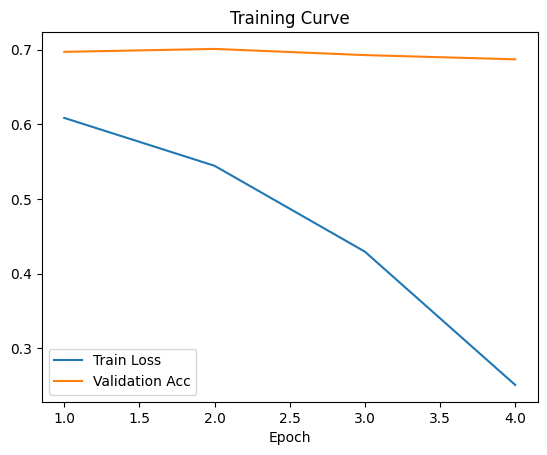

📊 Classification Report:
              precision    recall  f1-score   support

        fake       0.78      0.67      0.72      1323
        real       0.63      0.74      0.68       973

    accuracy                           0.70      2296
   macro avg       0.70      0.71      0.70      2296
weighted avg       0.71      0.70      0.70      2296



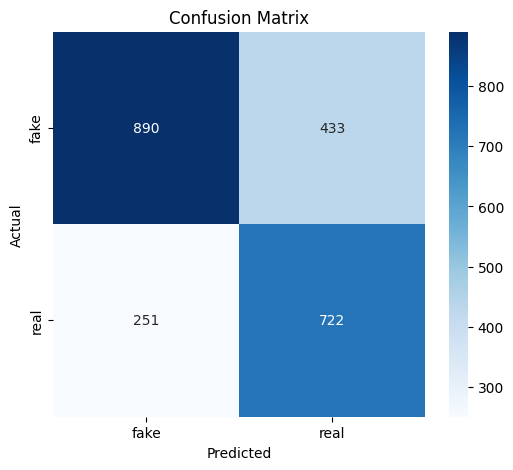


❌ Top 5 Misclassified Samples:

[3] Statement: It will cost $50,000 per enrollee in Obamacare over the next 10 years.
    ➤ True: fake | Pred: real

[6] Statement: America was the ONLY country that ended" slavery
    ➤ True: fake | Pred: real

[8] Statement: Says if the AHCA replaces Obamacare it will "significantly reduce insurance premiums in" North Carolina.
    ➤ True: real | Pred: fake

[13] Statement: More businesses went out of business last year than were started for the first time in our history.
    ➤ True: fake | Pred: real

[15] Statement: The Democratic health care law "added 12 years of solvency to Medicare.
    ➤ True: real | Pred: fake



,id,label,statement,date,subject,speaker,speaker_description,state_info,true_counts,mostly_true_counts,...,false_counts,pants_on_fire_counts,context,justification,clean_statement,clean_statement_svm,clean_statement_bert,true_label,predicted_label,correct
0,21750,0,Three doctors from the same hospital 'die sudd...,"July 28, 2022",facebook fact-checks;coronavirus,the gateway pundit,The Gateway Pundit is a conservative website.,NaN,1,1,...,15,3,a post,""" Segall’s obituary said he died ""after a un...",three doctors hospital suddenly week hospital ...,doctors same hospital suddenly same week hospi...,Three doctors from the same hospital 'die sudd...,0,0,True
1,18173,0,Say Joe Biden is a pedophile.,"July 17, 2020",facebook fact-checks,facebook posts,Posters on Facebook and other social media net...,NaN,24,50,...,1410,570,Facebook posts,Social media users that Biden is a pedophile....,say joe biden pedophile,say joe biden is pedophile,Say Joe Biden is a pedophile.,0,0,True
2,22673,0,A photo shows President Joe Biden and Ukrainia...,"February 20, 2023",facebook fact-checks;ukraine,viral image,"Graphics, pictures and charts shared on social...",NaN,4,13,...,711,331,an Instagram post,The image appears to show Biden and Zelenskyy ...,photo shows president joe biden ukrainian pres...,photo shows president joe biden ukrainian pres...,A photo shows President Joe Biden and Ukrainia...,0,0,True
3,9897,0,"It will cost $50,000 per enrollee in Obamacare...","January 27, 2015",health care;taxes;punditfact,stuart varney,Stuart Varney is a British business journalist...,NaN,0,0,...,1,0,"an interview on Fox News' ""America's Newsroom""","Varney said that it will cost taxpayers $50,00...",cost per enrollee obamacare next years,cost enrollee obamacare next years,"It will cost $50,000 per enrollee in Obamacare...",0,1,False
4,3855,1,The Federal Register - which houses all Washin...,"June 14, 2011",regulation,randy forbes,Randy Forbes is from Chesapeake and represents...,virginia,5,3,...,0,0,a statement,To recap: To argue that regulation is out of c...,federal register houses washington regulations...,federal register houses washington regulations...,The Federal Register - which houses all Washin...,1,1,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2291,14702,0,"Says ""Rosie O'Donnell apparently committed the...","June 4, 2018",campaign finance,ted cruz,"Ted Cruz is a U.S. Senator from Texas, first e...",national,8,22,...,47,11,an interview,"Cruz said, ""Rosie O’Donnell apparently committ...",says rosie apparently committed offense five t...,says rosie o'donnell apparently committed same...,"Says ""Rosie O'Donnell apparently committed the...",0,1,False
2292,21084,0,"An image shows ""Ukrainian soldiers praying.","March 6, 2022",facebook fact-checks;ukraine,facebook posts,Posters on Facebook and other social media net...,NaN,24,50,...,1410,570,a post,"In October 2017, SML Ministries shared the pho...",image shows ukrainian soldiers praying,image shows ukrainian soldiers praying,"An image shows ""Ukrainian soldiers praying.",0,0,True
2293,15667,1,Since 1938 the minimum wage has been increased...,"February 11, 2019",congress;income;labor;voting record;facebook f...,facebook posts,Posters on Facebook and other social media net...,NaN,24,50,...,1410,570,a Facebook post,"A social media meme claims that since 1938, th...",since minimum wage increased times raised time...,minimum wage has been increased times was rais...,Since 1938 the minimum wage has been increased...,1,1,True
2294,3313,0,Says Wisconsin Supreme Court Justice David Pro...,"March 16, 2011",legal issues,joanne kloppenburg,JoAnne Kloppenburg of Madison is state Court o...,wisconsin,0,2,...,1,1,a newspaper interview,"The fact that Prosser disavowed one statement,...",says wisconsin supreme court justice david pro...,says wisconsin supreme court justice david pro...,Says Wisconsin Supreme Court Justice David Pro...,0,0,True


In [9]:
from transformers import BertTokenizer

# 加载数据
train_df, val_df, test_df, class_names = load_and_prepare_binary_data(
    "/content/processed_train (2).csv",
    "/content/processed_valid (2).csv",
    "/content/processed_test (2).csv"
)

# Tokenizer & Dataset
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
train_set = MultiClassFakeNewsDataset(train_df, tokenizer, max_len=128)
val_set = MultiClassFakeNewsDataset(val_df, tokenizer, max_len=128)

# 模型
model = MultiClassBERTClassifier("bert-base-uncased", num_labels=2)

# 训练
model = train_multiclass_model(train_set, val_set, model, epochs=10, batch_size=16)

# 构建测试集数据集
test_set = MultiClassFakeNewsDataset(test_df, tokenizer, max_len=128)

# 加载最优模型参数（可选）
model.load_state_dict(torch.load("best_multiclass_model.pt"))

# 预测
preds = predict(model, test_set)

# 评估与可视化
analyze_predictions(preds, test_df)

